In [1]:
import pandas as pd
import numpy as np

# for pickling
import pickle

# Regexp
import re

# Visualization
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# for vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk 




In [2]:
# Importing the dataset


dataset_columns = ['sentiment', 'ids', 'date', 'flag', 'user', 'text']
dataset_encoding = 'ISO-8859-1'


df = pd.read_csv('./dataset/training.1600000.processed.noemoticon.csv', encoding=dataset_encoding, names=dataset_columns)

df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
# Data preprocessing
df = df[['sentiment', 'text']]

df['sentiment'] = df['sentiment'].replace(4, 1)

In [4]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
text, sentiment = list(df['text']), list(df['sentiment'])


In [6]:
text[:10]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ']

In [7]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [8]:
# data preprocessing
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 260 seconds


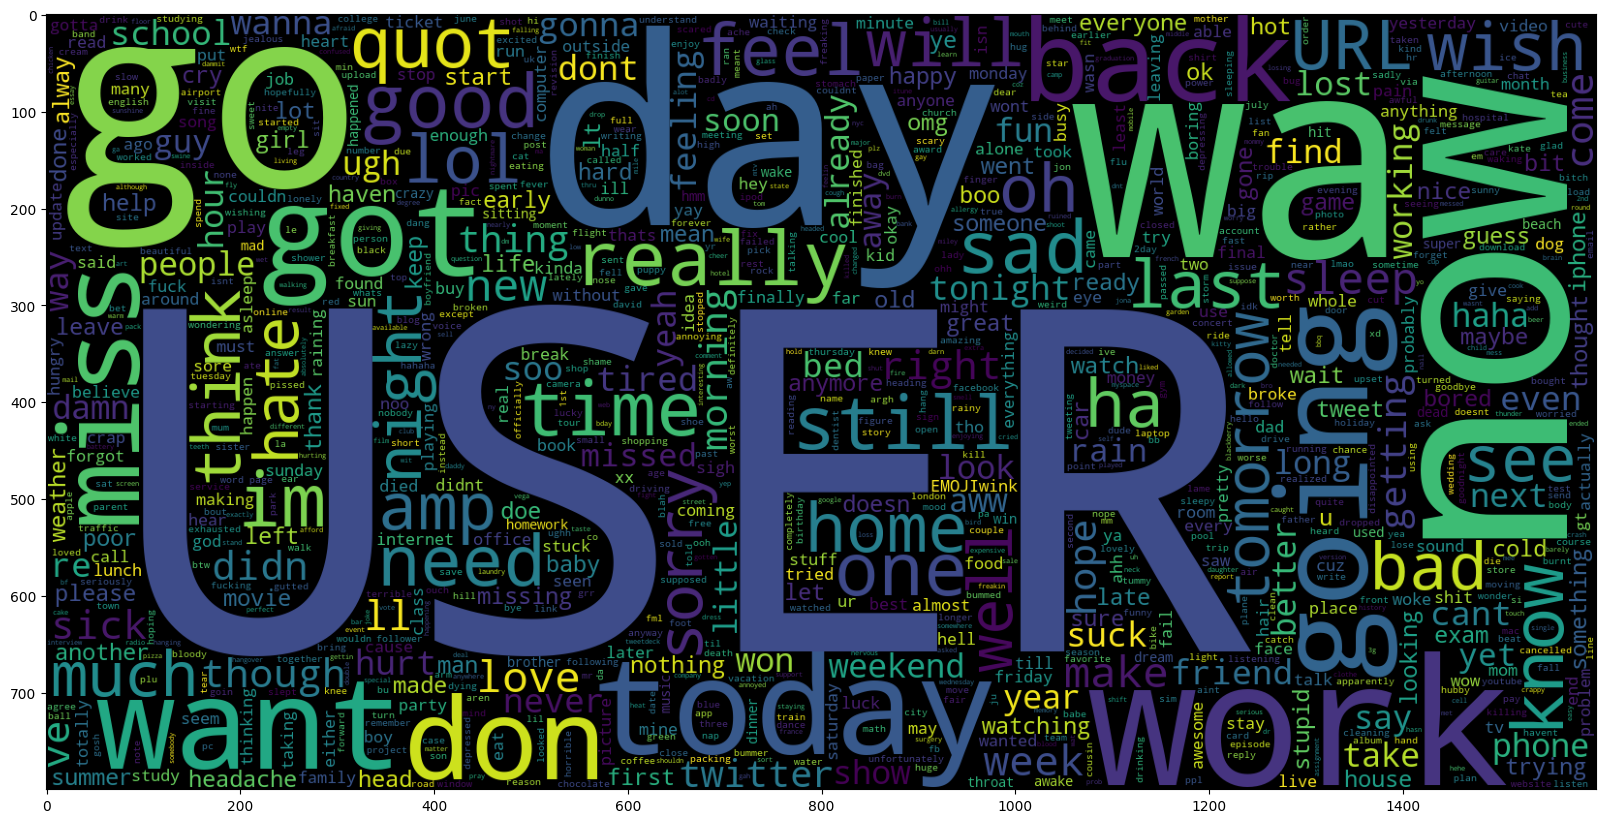

In [10]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

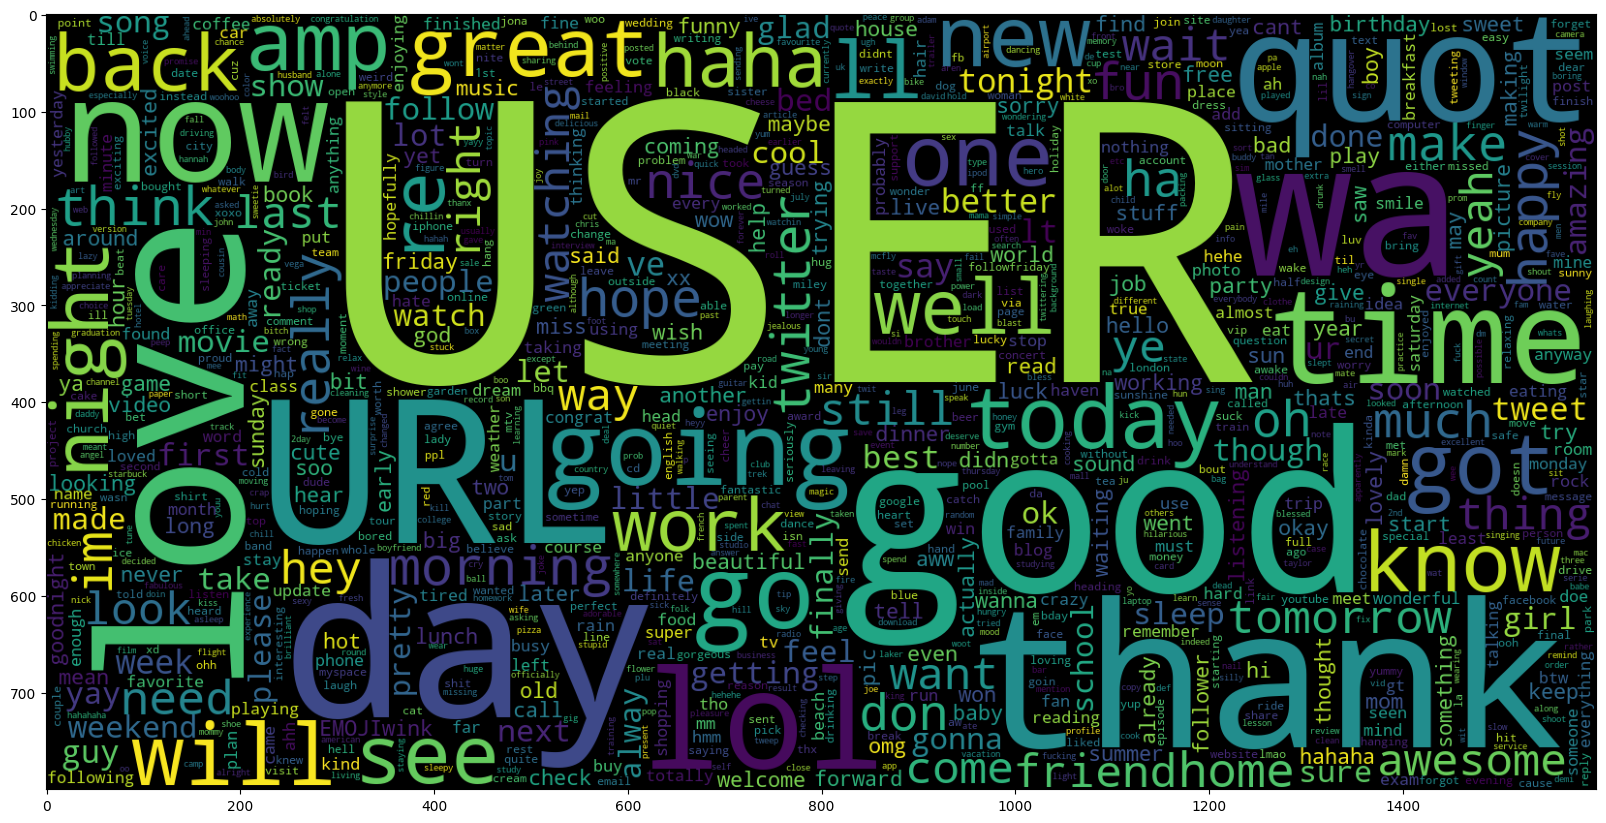

In [11]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [12]:
processedtext[:8000]

['USER URL aww that bummer you shoulda got david carr of third day to do it EMOJIwink ',
 'is upset that he can update his facebook by texting it and might cry a result school today also blah ',
 'USER dived many time for the ball managed to save 50 the rest go out of bound ',
 'my whole body feel itchy and like it on fire ',
 'USER no it not behaving at all mad why am here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time no see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have it ',
 'USER que me muera ',
 'spring break in plain city it snowing ',
 'just re pierced my ear ',
 'USER couldn bear to watch it and thought the ua loss wa embarrassing ',
 'USER it it count idk why did either you never talk to me anymore ',
 'USER would ve been the first but didn have gun not really though zac snyder just doucheclown ',
 'USER wish got to watch it with you miss you and USER how wa the premiere ',
 'hollis death sce

In [13]:
# Splitting of the dataset
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=0.05, random_state=0)

In [14]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

print(f"No of feature_words: {len(vectorizer.get_feature_names_out())}")

No of feature_words: 500000


In [15]:
# Transforming the dataset
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [16]:
# Modal Evaluation

def model_evaluation(model):
    y_pred = model.predict(X_test)

    print(f"{classification_report(y_test, y_pred)}")

    # compute confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Negative', 'Positive']
    groupNames = ['True Neg', 'False Pos', 'True Pos', 'False Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels= [f'{v1}\n{v2}' for v1, v2 in zip(groupNames, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt="", xticklabels=categories, yticklabels=categories)

    plt.xlabel("Predicted Values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual Values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size':18}, pad=20)

    

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



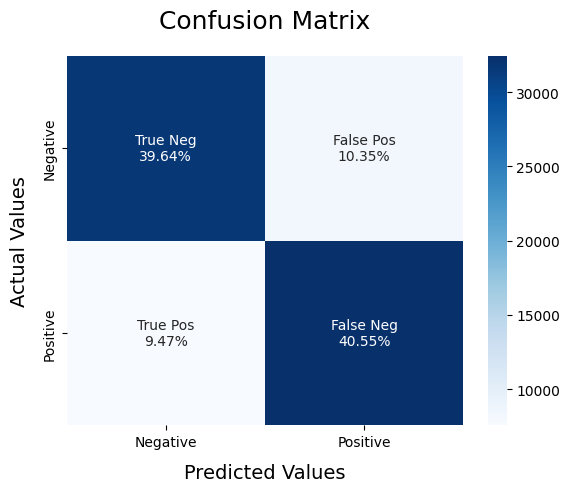

In [17]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_evaluation(BNBmodel)

C:\Users\sumit\anaconda3\envs\SentimentAnalysis\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



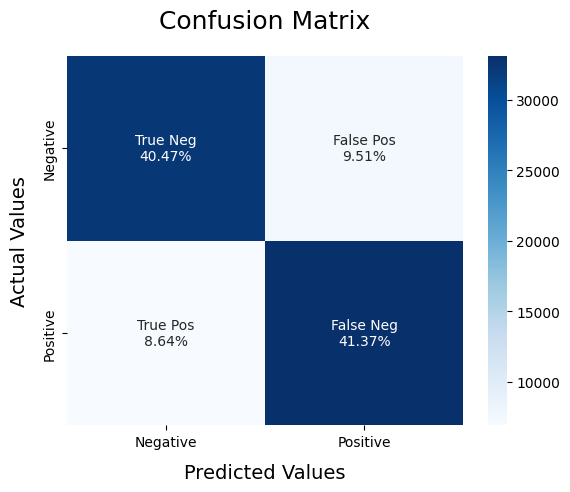

In [18]:
# Linear SVC Model

from sklearn.svm import LinearSVC

SVCModel = LinearSVC()
SVCModel.fit(X_train, y_train)
model_evaluation(SVCModel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



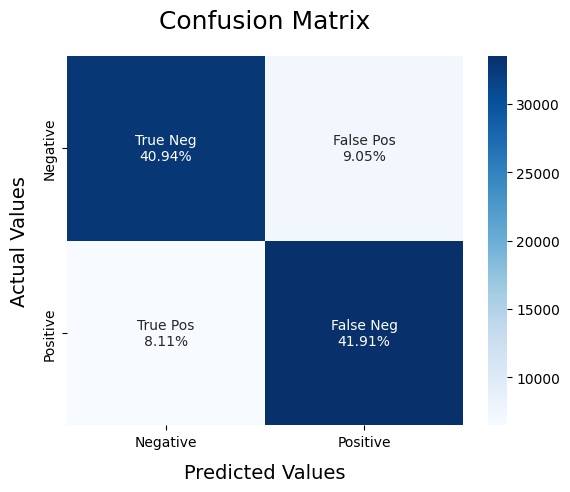

In [19]:
from sklearn.linear_model import LogisticRegression

LRModel = LogisticRegression(C = 2, max_iter=1000, n_jobs=-1)
LRModel.fit(X_train, y_train)
model_evaluation(LRModel)

In [20]:
# Saving the model
file = open('../sentiment-analysis/flask_backend/Models/vectoriser-ngram(1,2).pickle', 'wb')
pickle.dump(vectorizer, file)
file.close()

file = open('../sentiment-analysis/flask_backend/Models/Sentiment-LR.pickle', 'wb')
pickle.dump(LRModel, file)
file.close()

file = open('../sentiment-analysis/flask_backend/Models/Sentiment-BNB.pickle', 'wb')
pickle.dump(BNBmodel, file)
file.close()

In [21]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectorizer, model, text):
    textdata = vectorizer.transform(preprocess(text))
    sentiment = model.predict(textdata)

     # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df



In [22]:
if __name__=='__main__':
     # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]
    df = predict(vectorizer, LRModel, text)
    print(df.head())

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Negative


In [25]:
movie_reviews = [
    "I absolutely loved this movie! The plot was engaging, and the acting was superb.",
    "The cinematography was stunning, but the story felt a bit lacking. Overall, it was an okay film.",
    "This movie was a complete disappointment. The characters were poorly developed, and the plot was confusing.",
    "An emotional rollercoaster! The performances were outstanding, and the soundtrack was amazing.",
    "I expected more from this film. The dialogue felt forced, and the pacing was off."
]


df = predict(vectorizer, SVCModel, movie_reviews)
print(df.head())

                                                text sentiment
0  I absolutely loved this movie! The plot was en...  Positive
1  The cinematography was stunning, but the story...  Negative
2  This movie was a complete disappointment. The ...  Negative
3  An emotional rollercoaster! The performances w...  Positive
4  I expected more from this film. The dialogue f...  Negative
